In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks, savgol_filter, peak_widths
import os
import glob

In [8]:
DATA_DIR = '/content/drive/MyDrive/Colab Notebooks/HAR_Research_Project/transition/data/MHEALTHDATASET'

In [9]:
FS = 50
FINAL_CONFIG = {
    6: { # Waist bends (허리 굽히기)
        'name': 'Waist Bends',
        'sensors': ['acx', 'acy', 'acz'], # Chest 센서
        'min_dist_sec': 2.0,
        'prominence_scale': 0.5,
        'smooth_window': 51,
        'rel_height': 0.6
    },
    7: { # Frontal elevation of arms (팔 들기)
        'name': 'Arm Elevation',
        'sensors': ['arx', 'ary', 'arz'], # Right Arm 센서
        'min_dist_sec': 2.0,
        'prominence_scale': 0.3,
        'smooth_window': 51,
        'rel_height': 0.6
    },
    8: { # Crouching (무릎 굽히기)
        'name': 'Crouching',
        'sensors': ['alx', 'aly', 'alz'], # Left Ankle 센서
        'min_dist_sec': 2.0,
        'prominence_scale': 0.5,
        'smooth_window': 51,
        'rel_height': 0.6
    },
    12: { # Jump front & back (점프)
        'name': 'Jump Front/Back',
        'sensors': ['alx', 'aly', 'alz'], # Left Ankle 센서
        'min_dist_sec': 0.65,             # 빠른 동작 (0.65초)
        'prominence_scale': 1.5,          # 큰 충격
        'smooth_window': 15,              # 날카로운 피크 유지
        'rel_height': 0.6
    }
}

In [10]:
def load_mhealth_logs(data_dir):
    """
    mHealth_subject1.log ~ subject10.log 파일을 읽어서 하나로 합치는 함수.
    """
    # mHealth 데이터셋의 공식 컬럼 구조 (23개 컬럼 + 라벨)
    # 인덱스 기준:
    # 0-2: Chest Acc
    # 3-4: ECG (2개)
    # 5-7: Left Ankle Acc (alx, aly, alz)
    # 8-10: Left Ankle Gyro (glx, gly, glz)
    # 11-13: Left Ankle Mag
    # 14-16: Right Lower Arm Acc (arx, ary, arz)
    # 17-19: Right Lower Arm Gyro (grx, gry, grz)
    # 20-22: Right Lower Arm Mag
    # 23: Activity Label

    column_names = [
        'acx', 'acy', 'acz',          # Chest Acc
        'ecg1', 'ecg2',               # ECG
        'alx', 'aly', 'alz',          # Left Ankle Acc
        'glx', 'gly', 'glz',          # Left Ankle Gyro
        'mlx', 'mly', 'mlz',          # Left Ankle Mag
        'arx', 'ary', 'arz',          # Right Arm Acc
        'grx', 'gry', 'grz',          # Right Arm Gyro
        'mrx', 'mry', 'mrz',          # Right Arm Mag
        'Activity'                    # Label
    ]

    all_data = []

    print(f"'{data_dir}' 폴더에서 파일을 찾는 중...")

    # Subject 1부터 10까지 루프
    for subject_id in range(1, 11):
        file_name = f"mHealth_subject{subject_id}.log"
        file_path = os.path.join(data_dir, file_name)

        if not os.path.exists(file_path):
            print(f"경고: {file_name} 파일 없음.")
            continue

        try:
            # 로그 파일 읽기 (공백으로 구분)
            df = pd.read_csv(file_path, header=None, sep='\s+')

            # 컬럼 개수 확인
            if df.shape[1] != 24:
                print(f"{file_name} 컬럼 개수 이상. ({df.shape[1]}개). 체크 필요")
                continue

            # 컬럼명 할당
            df.columns = column_names

            # Subject ID 컬럼 추가
            df['subject'] = subject_id

            all_data.append(df)
            print(f"Loaded: Subject {subject_id} ({len(df)} samples)")

        except Exception as e:
            print(f"Error reading {file_name}: {e}")

    if not all_data:
        print("데이터 로딩 실패")
        return None

    # 하나로 합치기
    final_df = pd.concat(all_data, ignore_index=True)
    print(f"총 {len(final_df)} 샘플 로딩 완료")

    return final_df

<>:44: SyntaxWarning: invalid escape sequence '\s'
<>:44: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-4260380323.py:44: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(file_path, header=None, sep='\s+')


In [11]:
def generate_final_ground_truth(df, output_file='mhealth_final_gt.csv'):
    all_gt_list = []

    for act_id, config in FINAL_CONFIG.items():
        print(f"Analyzing Activity {act_id}: {config['name']}...")

        act_df = df[df['Activity'] == act_id].copy()
        if len(act_df) == 0:
            print("   데이터 없음. Skip.")
            continue

        subjects = act_df['subject'].unique()

        # 그래프 설정
        fig, axes = plt.subplots(len(subjects), 1, figsize=(12, 2.5 * len(subjects)), sharex=False)
        if len(subjects) == 1: axes = [axes]
        fig.suptitle(f"Final GT Check - {config['name']} (Act {act_id})", fontsize=14, y=1.02)

        for i, sub in enumerate(subjects):
            sub_data = act_df[act_df['subject'] == sub].reset_index(drop=True)

            # 센서 선택 및 Magnitude
            sx, sy, sz = config['sensors']
            acc_mag = np.sqrt(sub_data[sx]**2 + sub_data[sy]**2 + sub_data[sz]**2)

            # 스무딩
            smooth_signal = savgol_filter(acc_mag, window_length=config['smooth_window'], polyorder=3)

            # 피크 검출
            distance = int(config['min_dist_sec'] * FS)
            prominence = config['prominence_scale'] * np.std(smooth_signal)
            peaks, _ = find_peaks(smooth_signal, distance=distance, prominence=prominence)

            # 구간(Width) 추출
            results_half = peak_widths(smooth_signal, peaks, rel_height=config['rel_height'])
            start_indices = np.floor(results_half[2]).astype(int)
            end_indices = np.ceil(results_half[3]).astype(int)
            segments = list(zip(start_indices, end_indices))

            # GT 리스트 추가
            num_segments = len(segments)
            for (start, end) in segments:
                start = max(0, start)
                end = min(len(sub_data)-1, end)

                all_gt_list.append({
                    'subject': sub,
                    'activity_id': act_id,
                    'activity_name': config['name'],
                    'start_idx': start,
                    'end_idx': end,
                    'duration': end - start
                })

            # 그래프 그리기
            ax = axes[i]
            ax.plot(sub_data.index, smooth_signal, color='black', alpha=0.6, linewidth=1)
            ax.plot(peaks, smooth_signal[peaks], "x", color='red', markersize=7)
            for start, end in segments:
                ax.axvspan(start, end, color='green', alpha=0.2)

            status_color = 'blue' if 18 <= num_segments <= 22 else 'red'
            ax.set_title(f"Subject {sub}: {num_segments} segments", color=status_color, fontsize=10, fontweight='bold')
            ax.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    # CSV 저장
    gt_df = pd.DataFrame(all_gt_list)
    gt_df.to_csv(output_file, index=False)

    print("=" * 50)
    print(f"모든 분석 완료. 총 {len(gt_df)}개의 구간이 GT로 저장됨.")
    print(f"파일 저장 경로: {os.path.abspath(output_file)}")
    print("=" * 50)

    return gt_df

'/content/drive/MyDrive/Colab Notebooks/HAR_Research_Project/transition/data/MHEALTHDATASET' 폴더에서 파일을 찾는 중...
Loaded: Subject 1 (161280 samples)
Loaded: Subject 2 (130561 samples)
Loaded: Subject 3 (122112 samples)
Loaded: Subject 4 (116736 samples)
Loaded: Subject 5 (119808 samples)
Loaded: Subject 6 (98304 samples)
Loaded: Subject 7 (104448 samples)
Loaded: Subject 8 (129024 samples)
Loaded: Subject 9 (135168 samples)
Loaded: Subject 10 (98304 samples)
총 1215745 샘플 로딩 완료
Analyzing Activity 6: Waist Bends...


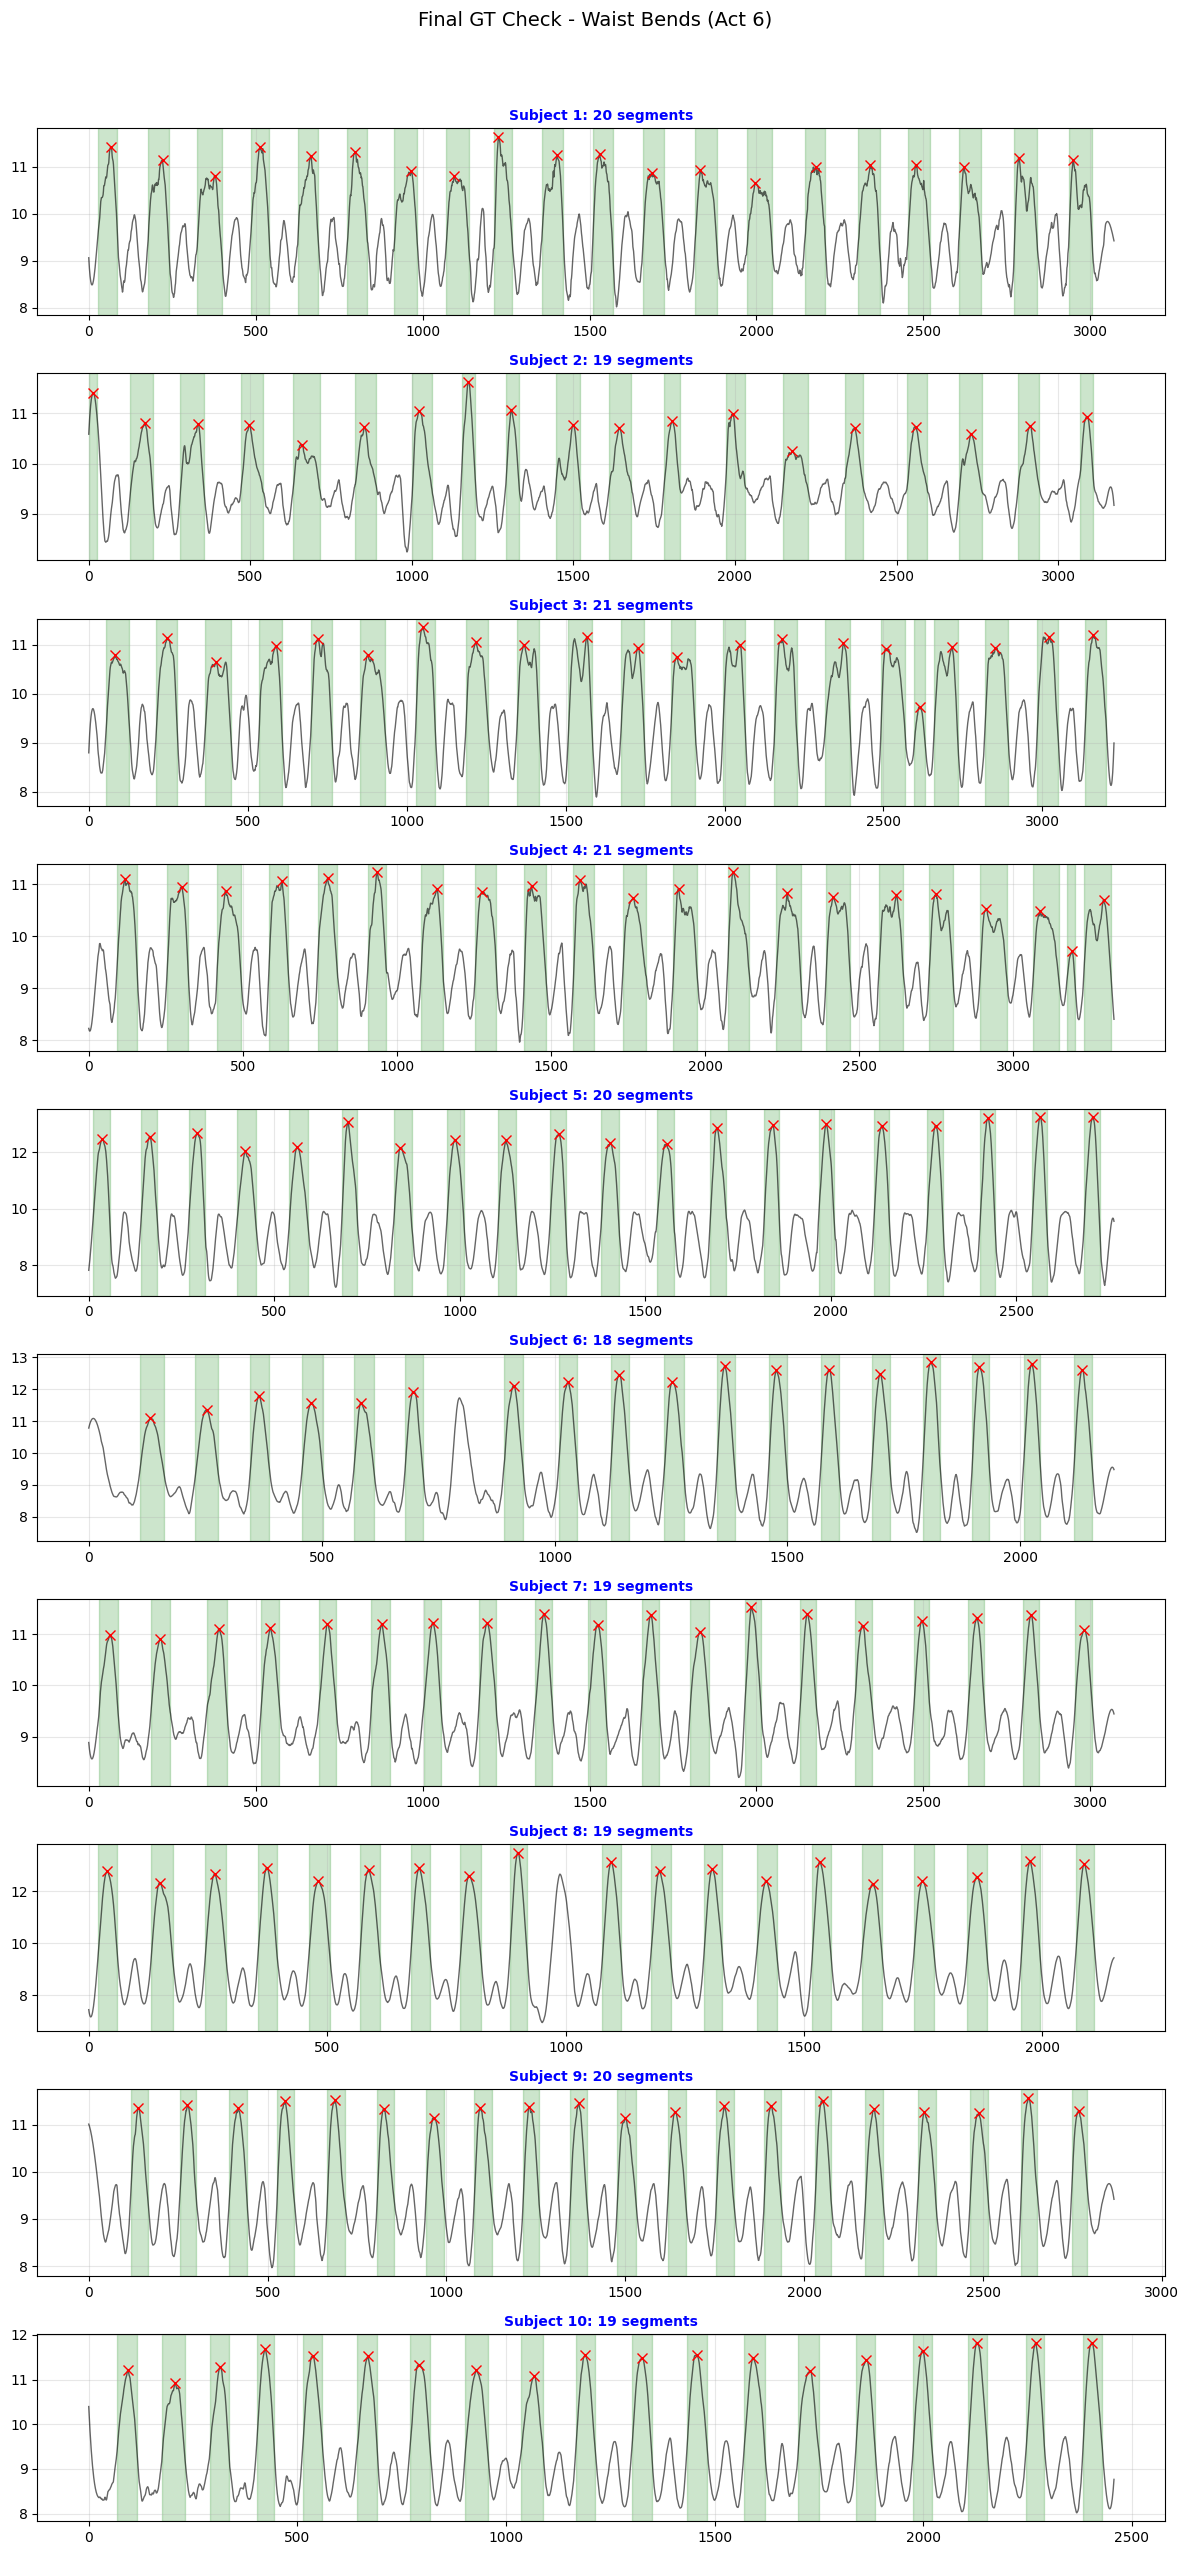

Analyzing Activity 7: Arm Elevation...


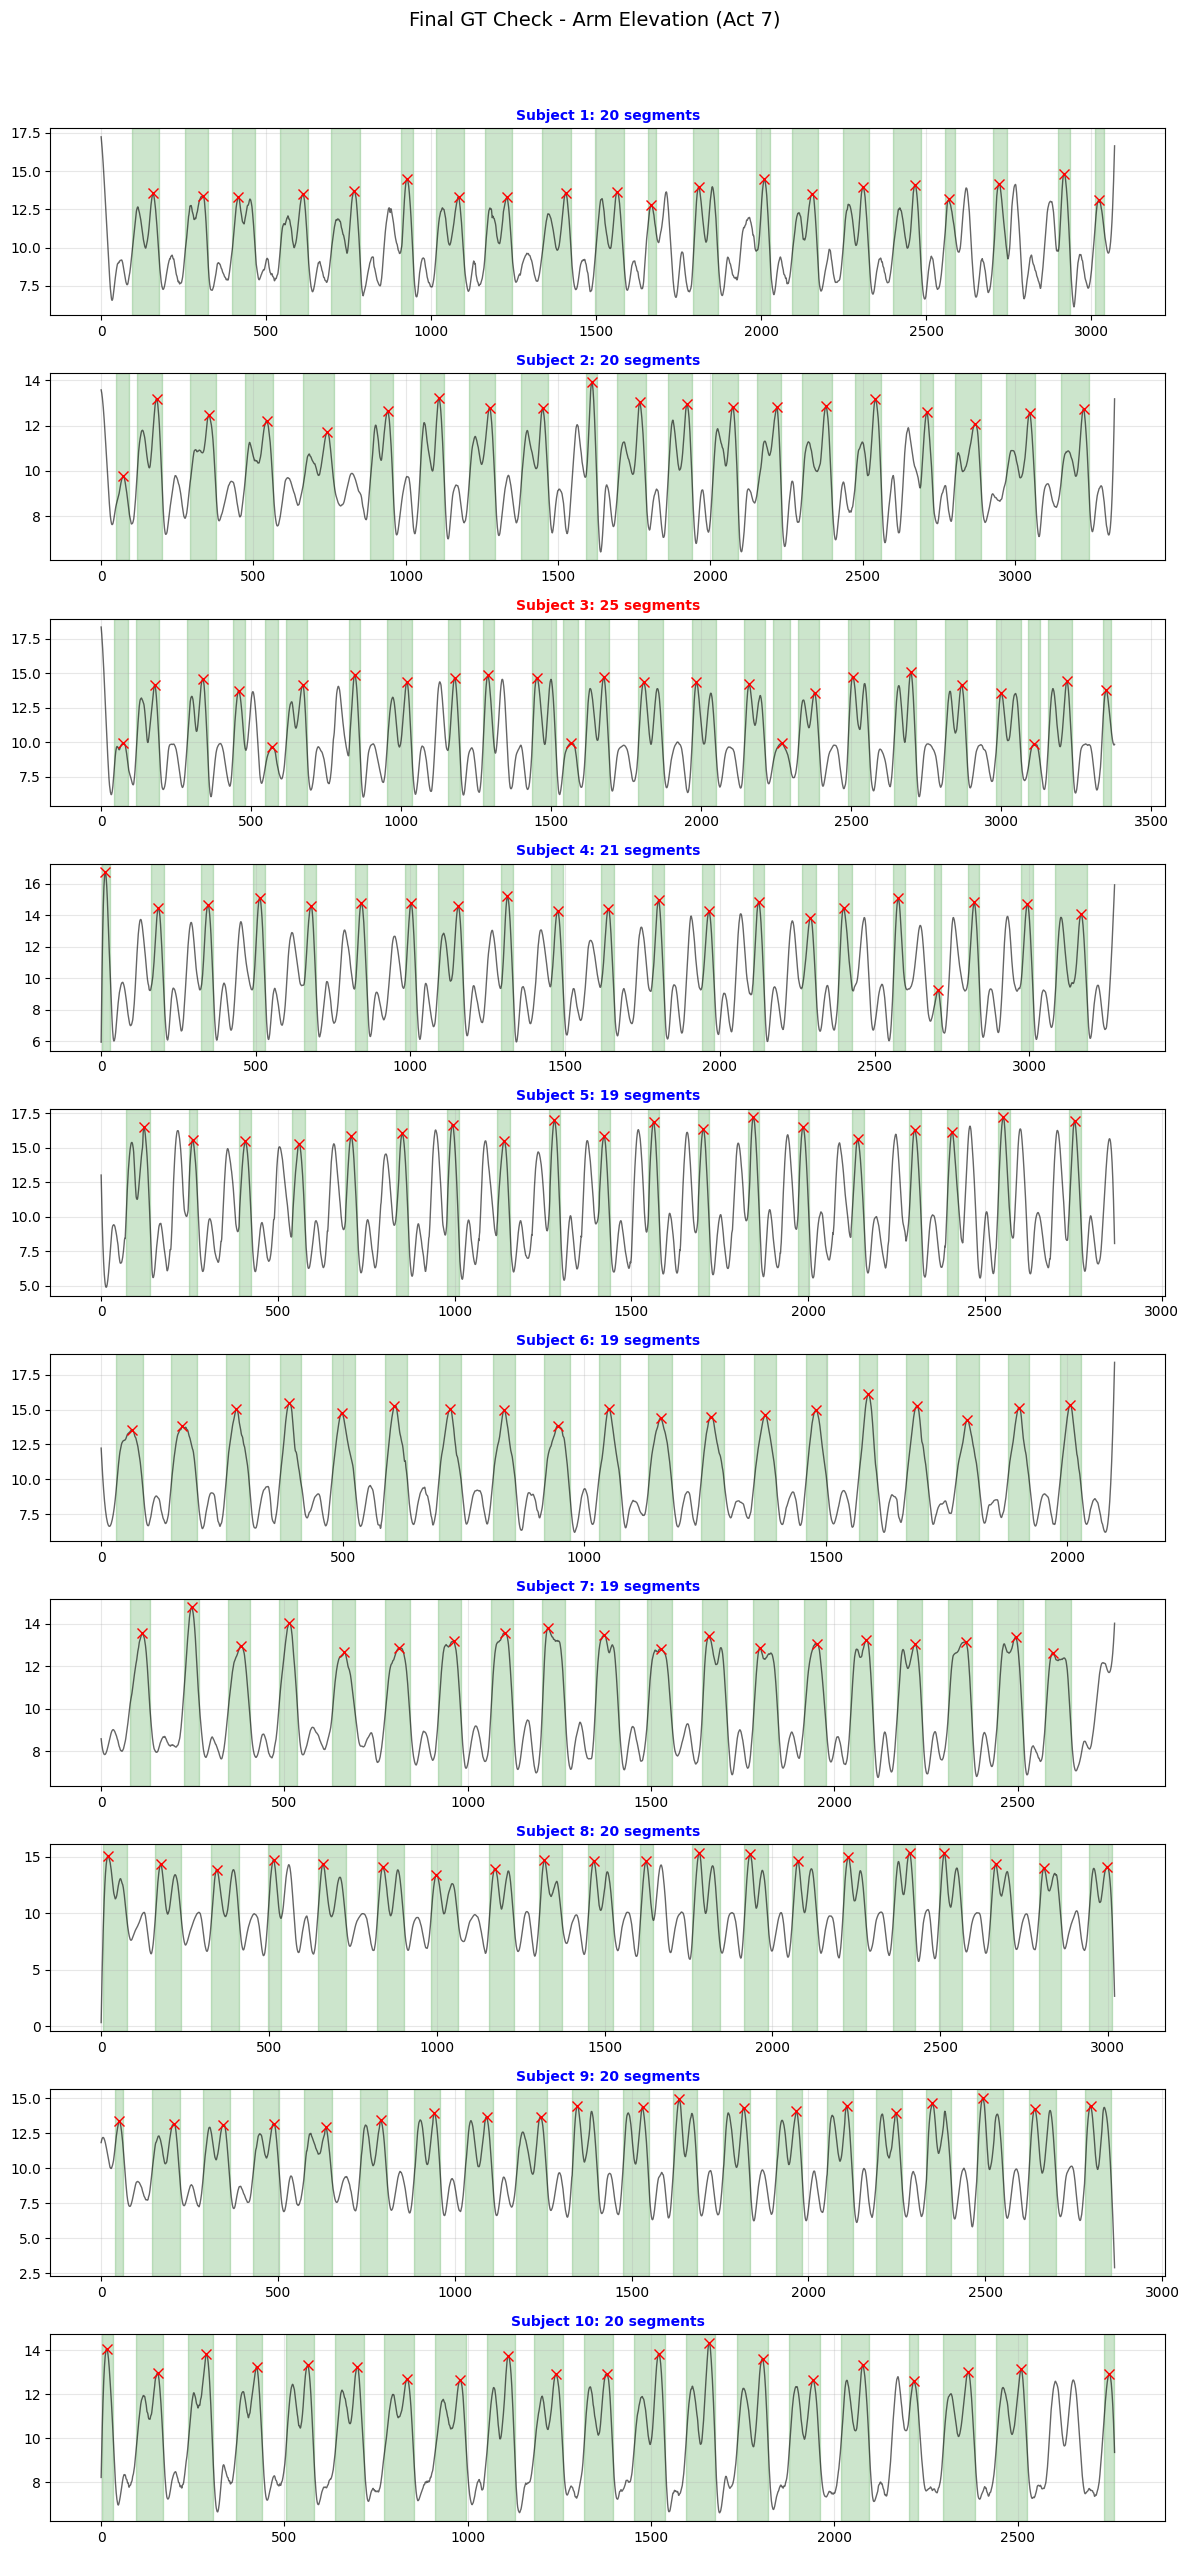

Analyzing Activity 8: Crouching...


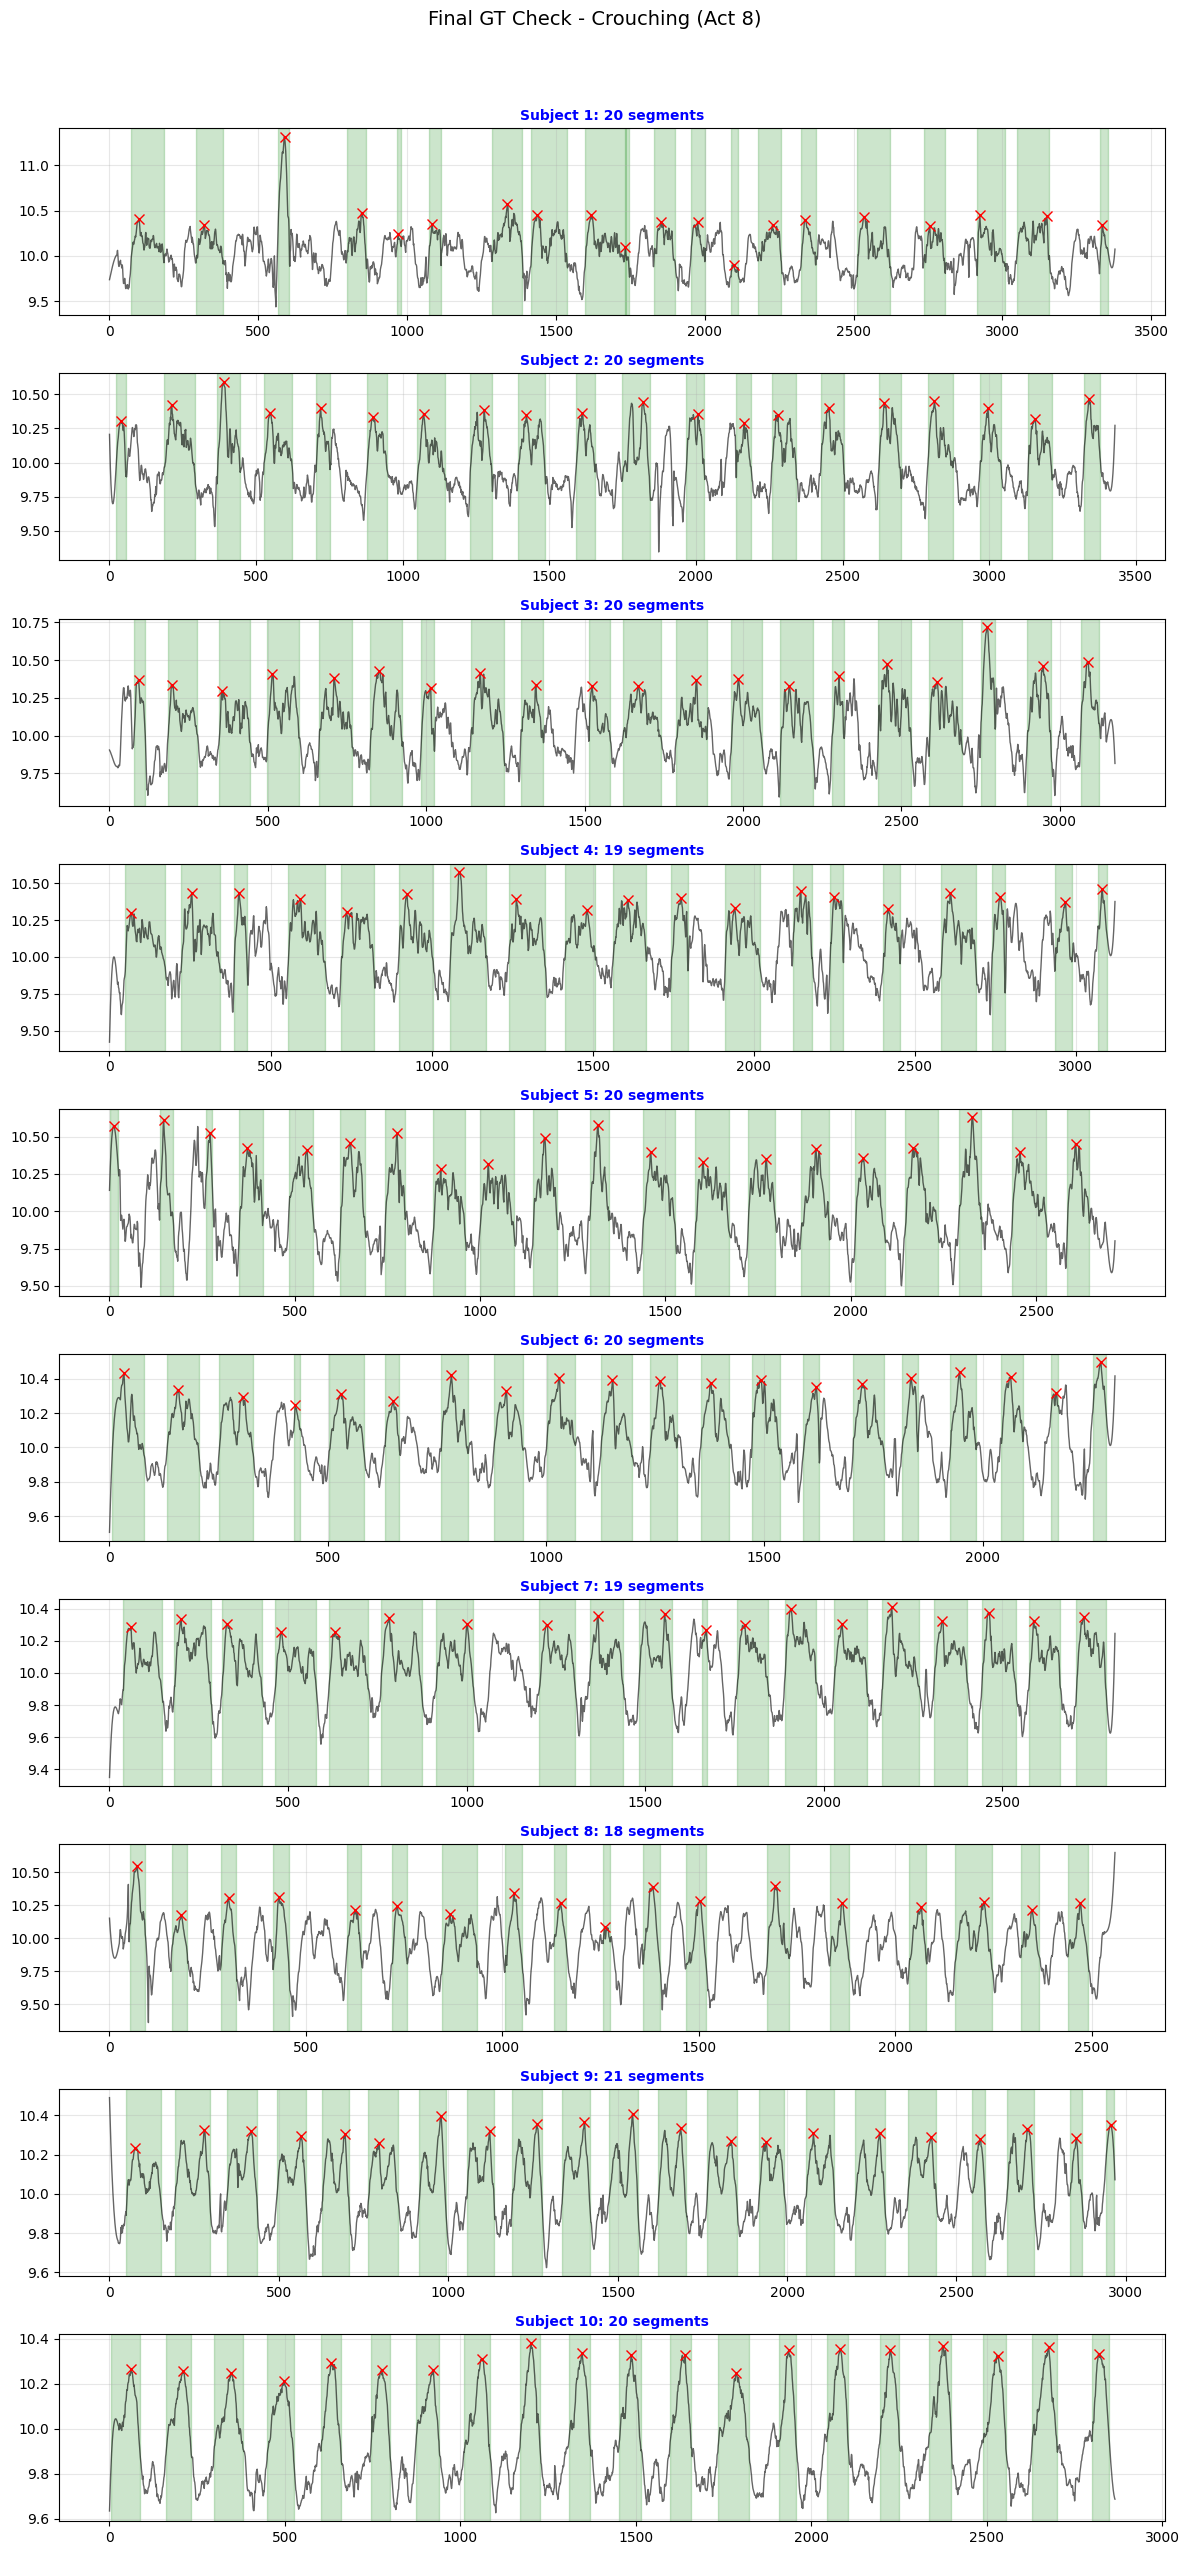

Analyzing Activity 12: Jump Front/Back...


In [ ]:
if __name__ == "__main__":
    # 1. 데이터 로드
    df = load_mhealth_logs(DATA_DIR)

    # 2. 로드 성공 시 분석 시작
    if df is not None:
        final_gt = generate_final_ground_truth(df, output_file='mhealth_final_gt.csv')

        # 3. 결과 미리보기
        if not final_gt.empty:
            print("[Preview of Ground Truth Data]")
            print(final_gt.head())
        else:
            print("생성된 GT가 없음")